# `mkregmap`

This script reads in a stack of regions (1 to N) and labels the pixels in the output map based on which region they belong to. In the case of overlaps, the last (highest N) is used.

In [1]:
ciaover 
echo Today is `date`

CIAO 4.11 Wednesday, December  5, 2018
  bindir      : /export/ciao-4.11/bin
  CALDB       : 4.8.2
Today is Mon Jan 21 16:40:20 EST 2019


In [2]:
# Routine to display images using ds9 in notebook
display_map()
{
img=$1
map=$2
png=$3
reg=$4

if test x${reg} == x
then
  region=""
else
  region="-region $reg"
fi

ds9 -geom 1550x824 -scale asinh -scale limits 0 200 \
  -zoom 2 -cmap load sunset-in-atlantis.sao  \
  -view info no -view panner no -view magnifier no -view buttons no -view colorbar no \
  $img \
  -frame new -cmap load $ASCDS_INSTALL/contrib/data/16_ramps.lut \
  $map -scale linear -scale mode minmax \
  $region -regions select all -regions color black -regions select none \
  -tile yes \
  -saveimage png $png -exit 

display < $png
}

In [3]:
#/bin/rm -rf ./tmp
#mkdir ./tmp
ASCDS_WORK_PATH=`pwd`/tmp

## Example 1, regular polar grid

In [4]:
dmstat smimg.fits cen- 
px=`stk_read_num ")dmstat.out_max_loc" 1 echo+`
py=`stk_read_num ")dmstat.out_max_loc" 2 echo+`

CONVOLVE
    min:	0.0066826618277 	      @:	( 4438.5 4550.5 )
    max:	126.03153992 	      @:	( 4274.5 3954.5 )
   mean:	6.624006713 
  sigma:	10.931784032 
    sum:	486056.36459 
   good:	73378 
   null:	59846 


In [5]:
mkregmap img.dss.fits out=pie.map bin=pie.img coord=sky clob+ \
  regions="circle(${px},${py},10);pgrid(${px},${py},10:1000:10,0:360:30)"

mkregmap
          infile = img.dss.fits
         regions = circle(4274.5,3954.5,10);pgrid(4274.5,3954.5,10:1000:10,0:360:30)
         outfile = pie.map
          binimg = pie.img
           coord = sky
         clobber = yes
         verbose = 1
            mode = ql



In [6]:
map2reg pie.map pie.reg clob+

map2reg
          infile = pie.map
         outfile = pie.reg
         verbose = 1
         clobber = yes
            mode = ql

1
399
200
598
201
2
599
400
3
600
202
401
4
601
402
203
5
602
403
204
6
603
404
205
7
604
405
206
8
605
406
207
9
607
407
208
10
608
408
209
11
609
210
409
12
610
410
211
13
411
611
212
14
412
612
213
15
613
413
214
16
414
614
215
17
415
616
216
18
416
617
217
417
19
619
218
418
20
620
219
419
21
621
220
420
22
622
221
421
23
623
222
422
24
624
223
423
25
625
224
424
26
626
225
425
27
628
226
426
28
227
631
427
29
228
632
428
30
229
633
429
31
230
634
430
32
231
635
431
33
232
636
34
432
233
637
35
433
234
638
36
434
235
640
37
435
236
643
38
436
237
644
39
437
238
645
438
40
239
646
41
439
240
647
42
440
241
648
43
441
242
649
44
442
243
652
45
443
244
655
46
444
245
656
47
445
246
657
48
446
247
658
49
447
248
659
50
448
249
660
51
449
250
661
52
450
251
664
53
451
252
667
54
452
253
668
55
453
254
669
56
454
255
670
57
455
256
671
58
456
257
672
59
457
258

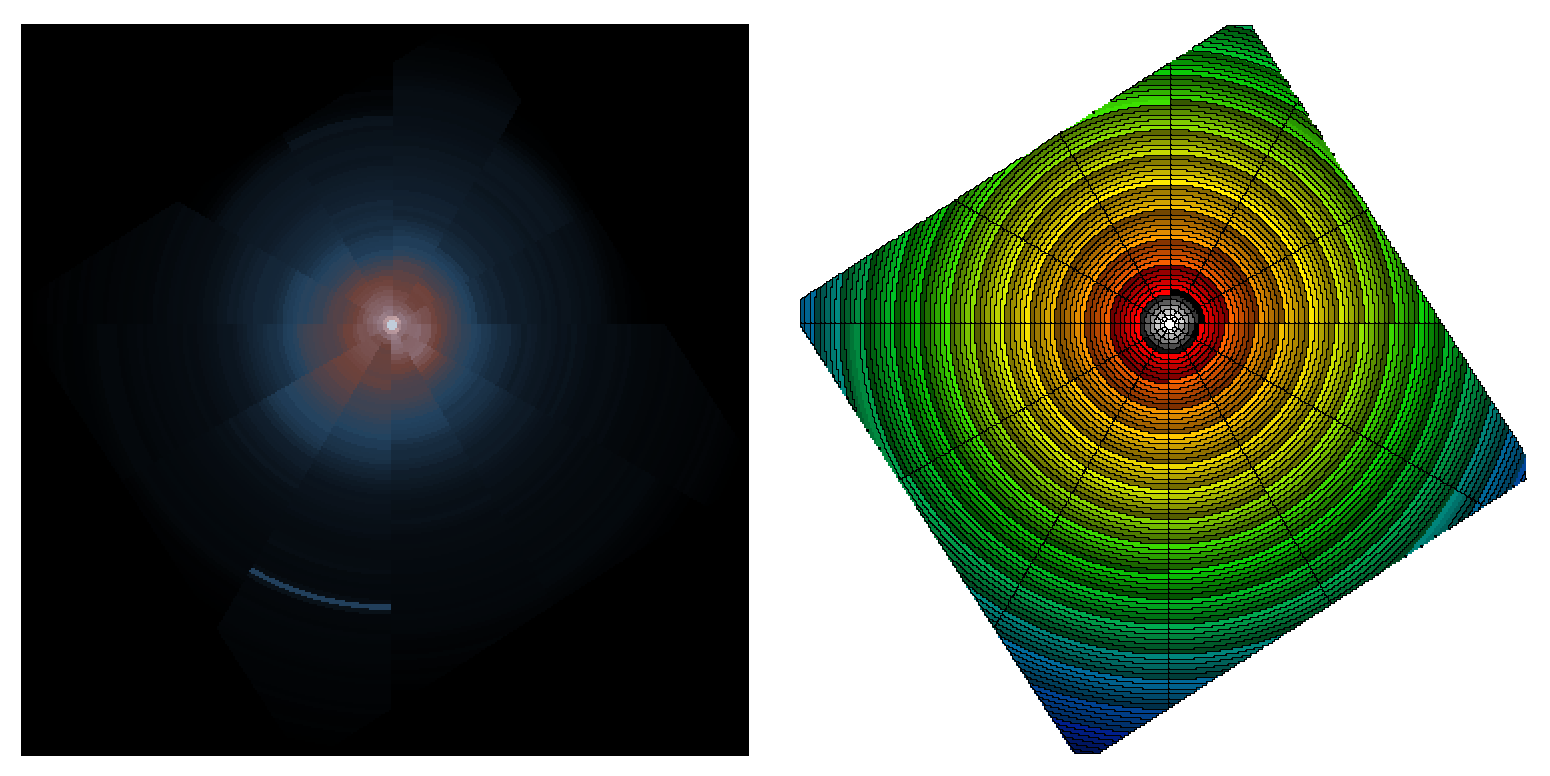

In [7]:
display_map pie.img pie.map pie.png pie.reg

Again, this isn't really _adaptive_ in the same was as other algorithms; but is shown here to illustrate the use of
stacks of regions using the `pgrid` syntax.

### Example 2, isophot-ellipse

In this example we use [`dmellipse`](http://cxc.cfa.harvard.edu/ciao/ahelp/dmellipse.html) to create a set of ellipses which enclose from 5% to 100% of the counts in the image in 2.5% increments.  These ellipses are then used as 
input to `mkregmap`


In [8]:
dmellipse infile=img.fits outfile=ellipses.fits  \
  fraction="lgrid(0.05:1.0:0.025)" shape=ellipse clob+ step=20 verb=1

# We need to reverse order so that smallest fraction is last region in file
# since the last region a pixel is used when there are overlaps.
dmsort ellipses.fits ellipses_sort.fits -component clob+

In [9]:
mkregmap infile=img.dss.fits outfile=ellipse.map bin=ellipse.img clob+ \
  regions='ellipses_sort.fits[#row=igrid(1:100:1)]'

mkregmap
          infile = img.dss.fits
         regions = ellipses_sort.fits[#row=igrid(1:100:1)]
         outfile = ellipse.map
          binimg = ellipse.img
           coord = sky
         clobber = yes
         verbose = 1
            mode = ql



In [10]:
map2reg ellipse.map ellipse.reg clob+

map2reg
          infile = ellipse.map
         outfile = ellipse.reg
         verbose = 1
         clobber = yes
            mode = ql

11
1
21
30
31
22
2
12
32
23
3
13
33
24
4
14
34
25
5
15
35
26
16
6
36
27
17
7
37
28
18
8
38
29
19
9
39
20
10


In [11]:
dmcopy "ellipse.reg[shape=Polygon]" ellipse_a.reg clob+

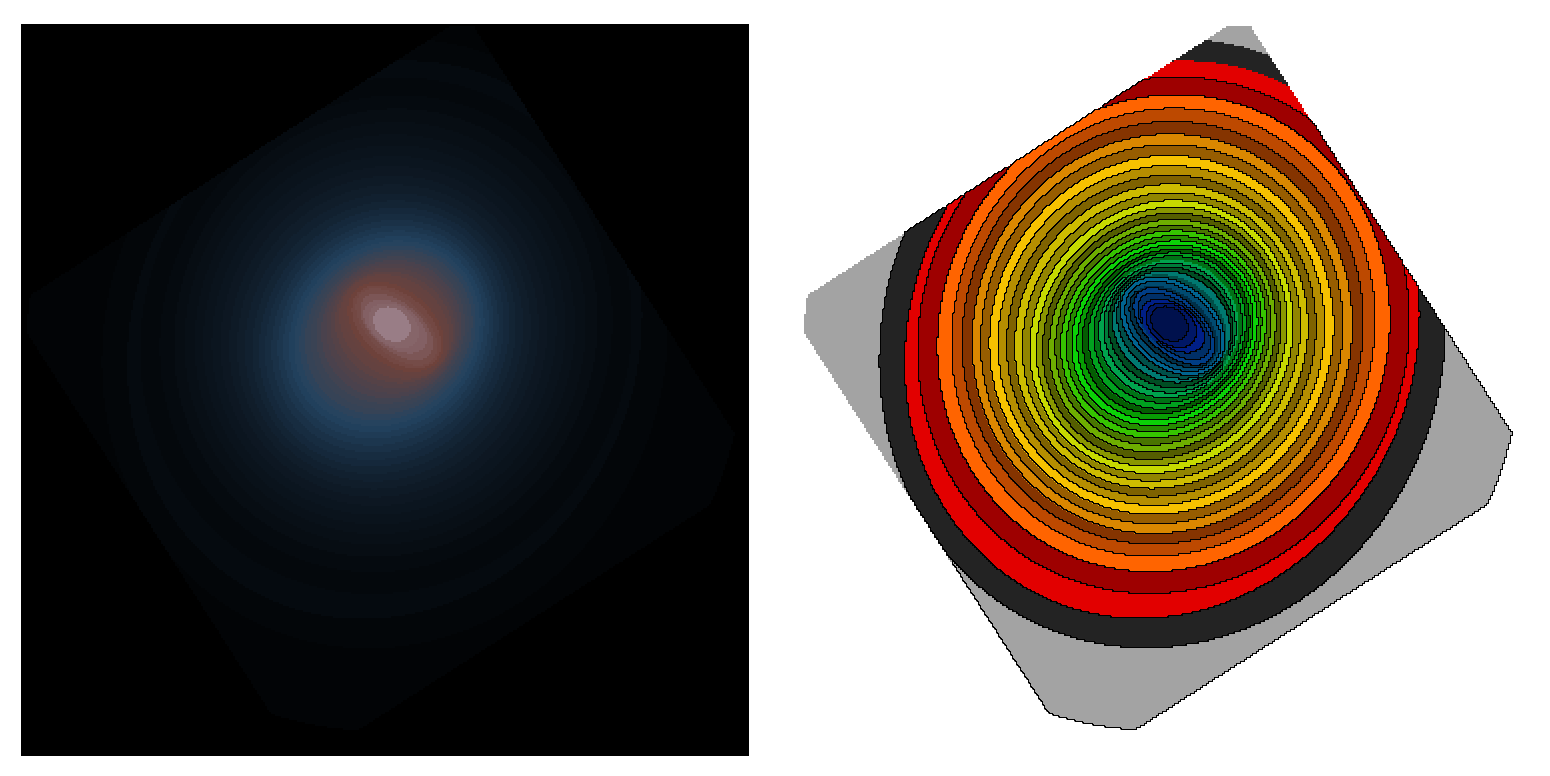

In [12]:
display_map ellipse.img ellipse.map ellipse.png ellipse_a.reg

We sorted the `dmellipse` output file so that the inner ellipses (smaller fraction) are last.
